## Find best model

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#data = pd.read_csv('../data/fullData_test.csv')
data = pd.read_csv('../data/fullData_test_toTransform.csv', index_col='Код объекта')
data.head()

,трассы,автомобильные мосты,Материал окон,Счетчик воды,гостевой паркинг,памятники архитектуры,культуры,пешеходные бульвары,Балкон,всего этажей,...,Стены,Адрес,Год постройки,Общая площадь,Высота потолков,Двор,Комнатность,подземный паркинг,Ремонт,цена
Код объекта,,,,,,,,,,,,,,,,,,,,,
5757236,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,5,...,Панельные,Древлянка,2017.0,30.60,2.50,открытый двор,1,0,Улучшенная черновая отделка,2390.0
5535905,0,0,Пластиковые,отсутствует,1,0,0,0,Нет балкона,5,...,Кирпичные,Голиковка,1979.0,18.00,2.55,открытый двор,1,0,Косметический ремонт,920.0
4644398,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,5,...,Панельные,Древлянка,2021.0,57.83,2.70,закрытый двор,3,0,Улучшенная черновая отделка,3250.0
5667276,0,0,Пластиковые,есть,0,0,0,0,Лоджия,16,...,Монолитные,Ключевая,2016.0,41.20,2.70,открытый двор,2,0,Косметический ремонт,3590.0
4644417,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,5,...,Панельные,Древлянка,2021.0,84.00,2.70,закрытый двор,4,0,Улучшенная черновая отделка,4500.0


In [3]:
X = data.drop(columns='цена')
Y = data['цена']

# data preprocessing

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class YearsTransformer(BaseEstimator, TransformerMixin):
    """Apply binarization and ohetransform to 'Год постройки' column"""
    def __init__(self, bin_split=5):
        self.bin_split = bin_split
        self.is_fitted = False
        self.ohe = OneHotEncoder(sparse=False)

    def fit(self, X, Y=None):
        bins = np.linspace(X.min(), X.max(), self.bin_split)
        self.bins = bins
        year = pd.cut(X, bins=self.bins, include_lowest=True)
        self.ohe.fit(year.to_numpy().reshape(-1, 1))
        cols_name = self.ohe.get_feature_names_out()
        self.cols_name = [col.removeprefix('x0_') for col in cols_name]
        self.is_fitted = True
        return self

    def transform(self, X):
        assert self.is_fitted, 'call fit() method first, or use fit_transform()'
        year = pd.cut(X, bins=self.bins, include_lowest=True)
        year_ohe = self.ohe.transform(year.to_numpy().reshape(-1, 1))
        return pd.DataFrame(year_ohe, index=X.index, columns=self.cols_name)

    def inverse_transform(self, X):
        raise NotImplementedError()
    
    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X)
    
    def get_feature_names_out(self, input_features):
        return list(self.cols_name)

class Renovationtransformer(BaseEstimator, TransformerMixin):
    column_values = {'Черновая отделка' :0, 'Улучшенная черновая отделка' :1, 'Требует ремонта':2, 'Частичный ремонт':3,
                        'Косметический ремонт':4, 'Современный ремонт':5, 'Ремонт по дизайн проекту':6}
    def __init__(self):
        self.is_fitted = False

    def fit(self, X, Y=None):
        self.is_fitted = True
        return self

    def transform(self, X):
        assert self.is_fitted, 'call fit() method first, or use fit_transform()'
        X_labeled_renovation = X.replace(column_values)
        return X_labeled_renovation.to_frame()

    def inverse_transform(self, X):
        raise NotImplementedError()

    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X)

    def get_feature_names_out(self, input_features):
        return [input_features]

preprocess different columns with different transformers using ColumnTransformer

In [6]:
oheCols = ['Материал окон', 'Балкон', 'Серия', 'Стены',
           'Адрес', 'Ремонт']
oheColsDropFirst = ['Счетчик воды', 'Двор']
scaleCols = ['Общая площадь', 'Высота потолков']

In [7]:
ct = ColumnTransformer([
    ("year_build", YearsTransformer(), 'Год постройки'),
    #("renovation", Renovationtransformer(), "Ремонт"),
    ("ohe", OneHotEncoder(sparse=False), oheCols),
    ("ohe_drop", OneHotEncoder(sparse=False, drop='first'), oheColsDropFirst),
    ("scaling", StandardScaler(), scaleCols)
],
remainder='passthrough'
)

In [8]:
X_preproced = ct.fit_transform(X)
X_preproced = pd.DataFrame(X_preproced, index=X.index, columns = ct.get_feature_names_out())
X_preproced.head()

,"year_build__(1933.999, 1955.75]","year_build__(1955.75, 1977.5]","year_build__(1977.5, 1999.25]","year_build__(1999.25, 2021.0]",ohe__Материал окон_Деревянные,ohe__Материал окон_Пластиковые,ohe__Материал окон_Пластиковые/деревянные,ohe__Балкон_Балкон и лоджия,ohe__Балкон_Два балкона и более,ohe__Балкон_Есть балкон,...,scaling__Высота потолков,remainder__трассы,remainder__автомобильные мосты,remainder__гостевой паркинг,remainder__памятники архитектуры,remainder__культуры,remainder__пешеходные бульвары,remainder__всего этажей,remainder__Комнатность,remainder__подземный паркинг
Код объекта,,,,,,,,,,,,,,,,,,,,,
5757236,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.339998,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0
5535905,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.045546,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0
4644398,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.202179,0.0,0.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0
5667276,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.202179,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0
4644417,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.202179,0.0,0.0,1.0,0.0,0.0,0.0,5.0,4.0,0.0


<AxesSubplot:xlabel='scaling__Высота потолков', ylabel='Count'>

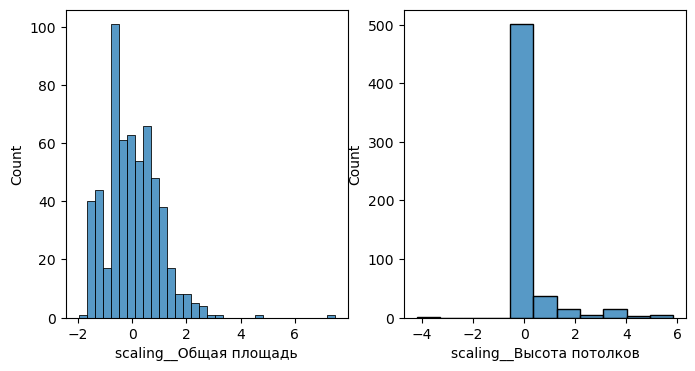

In [9]:
data = X_preproced[[col for col in X_preproced.columns if 'scaling' in col]]
f, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(data.iloc[:,0], ax=ax[0])
sns.histplot(data.iloc[:,1], ax=ax[1])

In [10]:
# gridsearch for DecisionTree
estimator = DecisionTreeRegressor()
params = {'max_depth': [None,3,4,5,6,7,8,9,10,15,17,20],
         'min_samples_split':[n for n in range(2,10)],
          'min_samples_leaf' : [i for i in range(1,10)],
          'random_state' : [42],
         'min_samples_leaf': [n for n in range(1,10)],
         'max_features':[n_features/10 for n_features in range(1,11)]}

In [11]:
grid = GridSearchCV(estimator, params, verbose=True)
#grid.fit(X_preproced, Y)
#best_params = grid.best_params_
#best_params

In [12]:
best_params = {'max_depth': 8,
 'max_features': 0.8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'random_state': 42}

In [13]:
#best_params = grid.best_params_
#best_params

In [14]:
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

In [15]:
metrics = [mean_squared_error, mean_absolute_error]

In [16]:
models = [DecisionTreeRegressor(**best_params),LinearRegression(), 
          Lasso(alpha=0.25, random_state=42),
          Ridge(alpha=0.05, random_state=42),
          RandomForestRegressor(random_state=42),
          SGDRegressor(penalty='l2', random_state=42),
          KNeighborsRegressor(50),
          LinearSVR(random_state=42)
         ]

Высокая корреляция между:  
- трассы & автомобильные мосты;
- памятники культуры & архитектуры & пешеходные бульвары;
- комнатность & общая площадь.  
Что вполне ожидаемо

In [17]:
corr = X_preproced.corr()
high_pos_corr = corr[(corr>=0.65)].dropna(how='all')
high_pos_corr.to_numpy()[np.diag_indices_from(high_pos_corr.to_numpy())] = np.nan  # mark diagnoal els as NaN
high_pos_corr = high_pos_corr.dropna(how='all')

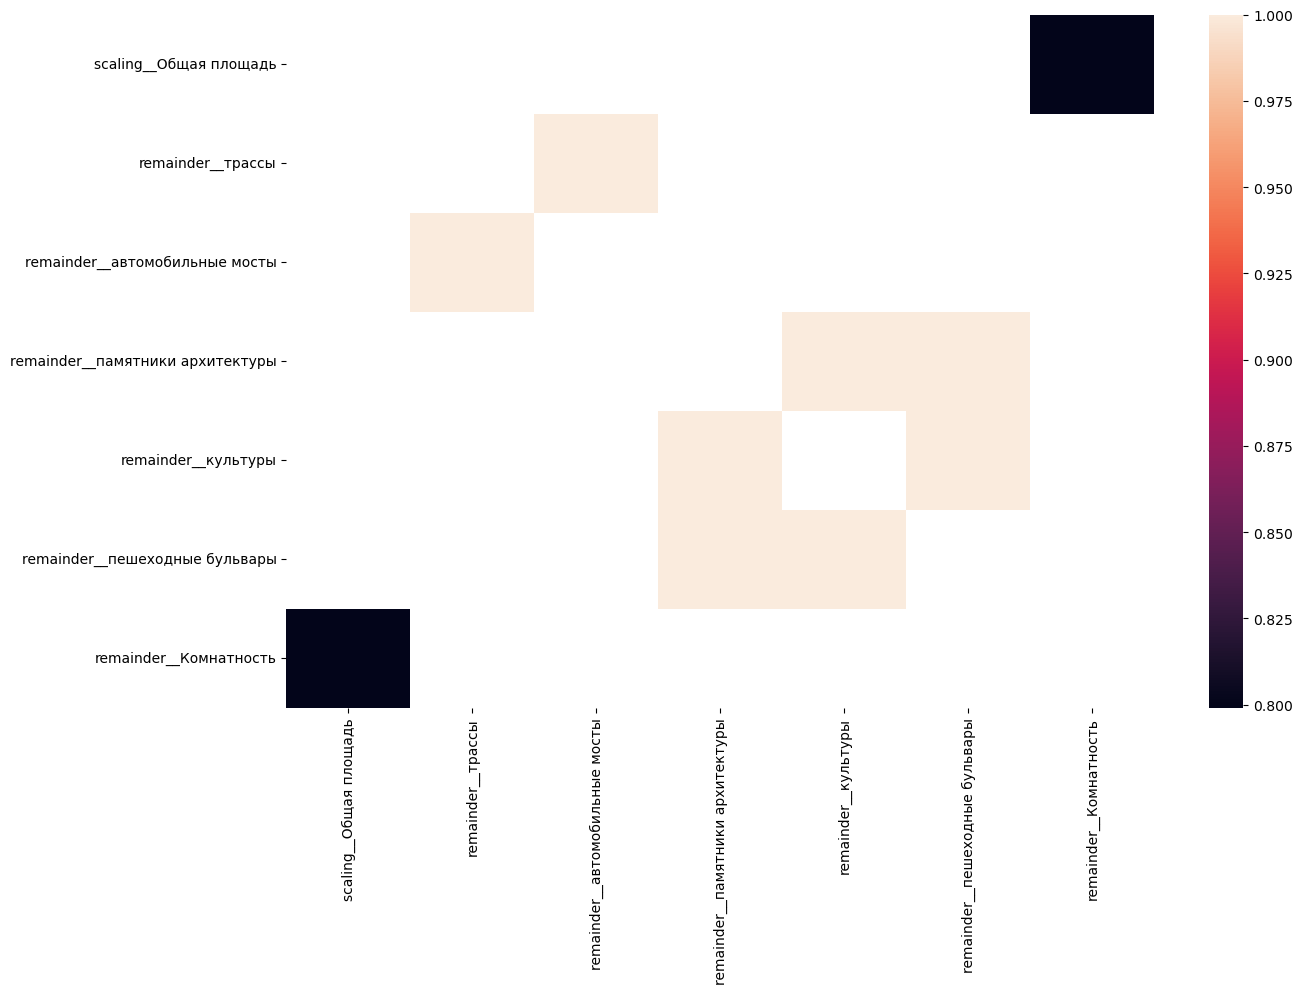

In [18]:
plt.figure(figsize=(14,9))
heatmap = sns.heatmap(high_pos_corr.loc[:, high_pos_corr.index])
fig = heatmap.get_figure()
#fig.savefig("../images/high_positive.png", dpi=300, bbox_inches='tight')

Высокая негативная корреляция между:  
- Материал окон: деревянные vs. пластиковые;
- Есть балкон vs. нет балкона;
-  закрытый двор vs. открытый двор

In [19]:
corr = X_preproced.corr()
high_neg_corr = corr[corr<=-0.65].dropna(how='all')

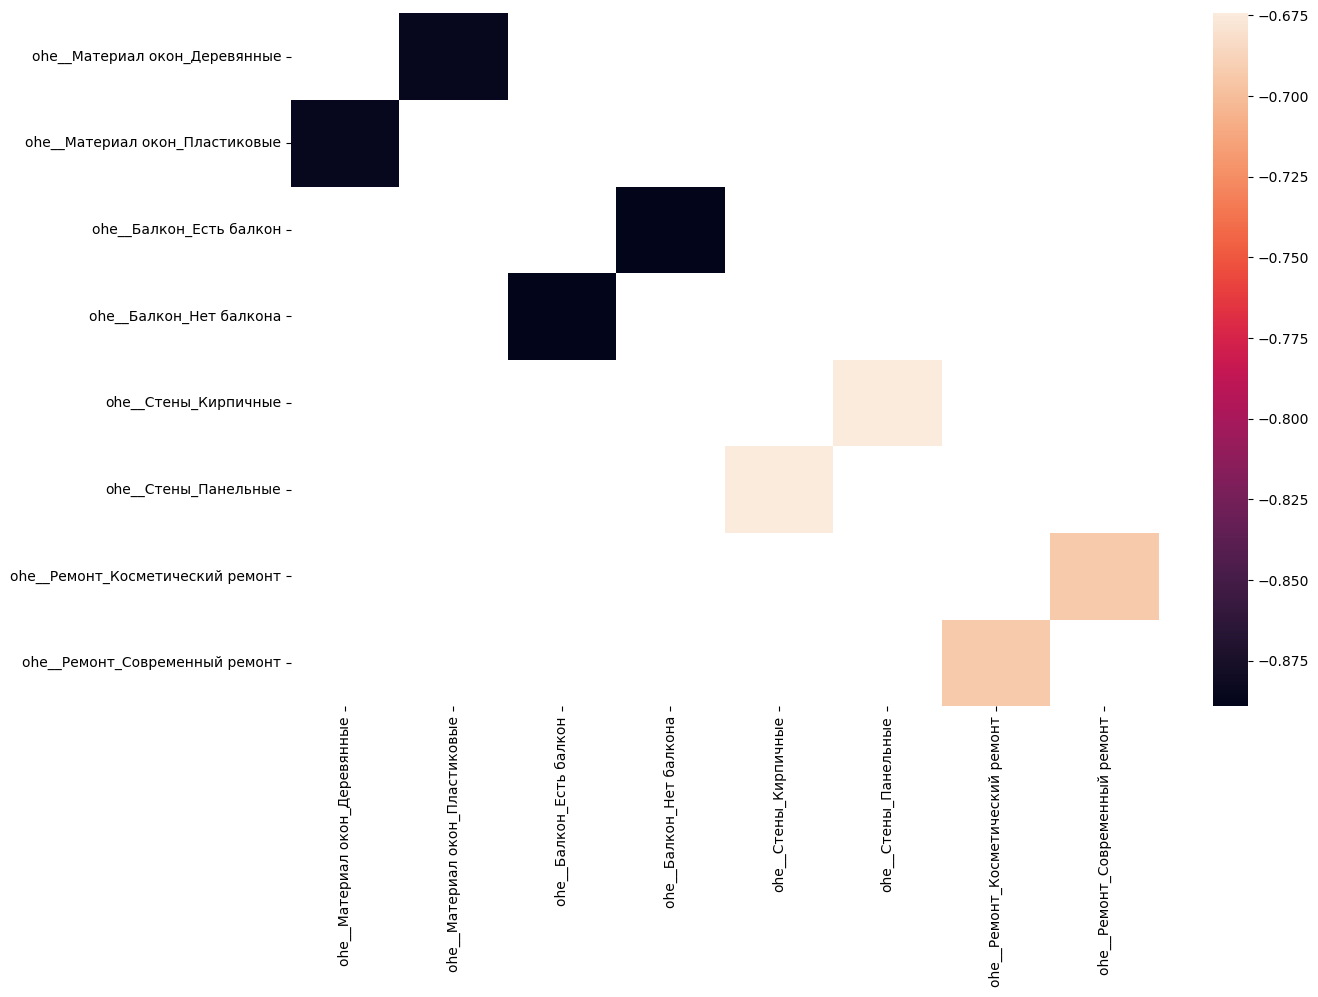

In [20]:
plt.figure(figsize=(14,9))
heatmap = sns.heatmap(high_neg_corr.loc[:, high_neg_corr.index])
fig = heatmap.get_figure()
#fig.savefig("../images/high_negiative.png", dpi=300, bbox_inches='tight')

In [21]:
cols = ['ohe__Материал окон_Деревянные', 'ohe__Балкон_Нет балкона', 'ohe__Стены_Панельные']

In [22]:
X.corrwith(Y)

трассы                   0.062978
автомобильные мосты      0.062978
гостевой паркинг         0.053375
памятники архитектуры    0.047461
культуры                 0.047461
пешеходные бульвары      0.047461
всего этажей             0.208282
Год постройки            0.300951
Общая площадь            0.788724
Высота потолков          0.216977
Комнатность              0.666749
подземный паркинг        0.117690
dtype: float64

In [23]:
X

,трассы,автомобильные мосты,Материал окон,Счетчик воды,гостевой паркинг,памятники архитектуры,культуры,пешеходные бульвары,Балкон,всего этажей,Серия,Стены,Адрес,Год постройки,Общая площадь,Высота потолков,Двор,Комнатность,подземный паркинг,Ремонт
Код объекта,,,,,,,,,,,,,,,,,,,,
5757236,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,5,Инд,Панельные,Древлянка,2017.0,30.60,2.50,открытый двор,1,0,Улучшенная черновая отделка
5535905,0,0,Пластиковые,отсутствует,1,0,0,0,Нет балкона,5,Общ,Кирпичные,Голиковка,1979.0,18.00,2.55,открытый двор,1,0,Косметический ремонт
4644398,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,5,Инд,Панельные,Древлянка,2021.0,57.83,2.70,закрытый двор,3,0,Улучшенная черновая отделка
5667276,0,0,Пластиковые,есть,0,0,0,0,Лоджия,16,Инд,Монолитные,Ключевая,2016.0,41.20,2.70,открытый двор,2,0,Косметический ремонт
4644417,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,5,Инд,Панельные,Древлянка,2021.0,84.00,2.70,закрытый двор,4,0,Улучшенная черновая отделка
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891833,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,9,75,Панельные,Кукковка,1985.0,39.80,2.50,открытый двор,1,0,Современный ремонт
4671111,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,5,Инд,Панельные,Ключевая,2012.0,36.60,2.50,открытый двор,1,0,Косметический ремонт
5193363,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,5,Инд,Кирпичные,Октябрьский,1963.0,30.60,2.50,открытый двор,1,0,Косметический ремонт


In [24]:
X_preproced.columns

Index(['year_build__(1933.999, 1955.75]', 'year_build__(1955.75, 1977.5]',
       'year_build__(1977.5, 1999.25]', 'year_build__(1999.25, 2021.0]',
       'ohe__Материал окон_Деревянные', 'ohe__Материал окон_Пластиковые',
       'ohe__Материал окон_Пластиковые/деревянные',
       'ohe__Балкон_Балкон и лоджия', 'ohe__Балкон_Два балкона и более',
       'ohe__Балкон_Есть балкон', 'ohe__Балкон_Лоджия',
       'ohe__Балкон_Нет балкона', 'ohe__Серия_1-335', 'ohe__Серия_1-335А',
       'ohe__Серия_2-68-1-0', 'ohe__Серия_335-с', 'ohe__Серия_75 ',
       'ohe__Серия_75.1, 3-75', 'ohe__Серия_А-1', 'ohe__Серия_Бреж',
       'ohe__Серия_Инд', 'ohe__Серия_Общ', 'ohe__Серия_Хрущ',
       'ohe__Стены_Блочные', 'ohe__Стены_Деревянные', 'ohe__Стены_Кирпичные',
       'ohe__Стены_Монолитные', 'ohe__Стены_Панельные', 'ohe__Адрес_Голиковка',
       'ohe__Адрес_Древлянка', 'ohe__Адрес_Зарека', 'ohe__Адрес_Ключевая',
       'ohe__Адрес_Кукковка', 'ohe__Адрес_Октябрьский',
       'ohe__Адрес_Первомайский', 

In [26]:
correlated_vars = X_preproced.corrwith(Y).map(abs).sort_values()
correlated_vars

ohe__Стены_Блочные                           0.002182
ohe__Серия_Бреж                              0.004115
ohe__Серия_Хрущ                              0.009891
ohe__Ремонт_Черновая отделка                 0.010944
ohe__Материал окон_Пластиковые/деревянные    0.014463
ohe__Серия_1-335                             0.014530
ohe__Серия_А-1                               0.024088
ohe__Серия_75.1, 3-75                        0.024437
ohe__Серия_2-68-1-0                          0.026255
ohe__Серия_335-с                             0.032505
ohe__Балкон_Балкон и лоджия                  0.045276
remainder__культуры                          0.047461
remainder__пешеходные бульвары               0.047461
remainder__памятники архитектуры             0.047461
remainder__гостевой паркинг                  0.053375
ohe__Ремонт_Требует ремонта                  0.062747
remainder__автомобильные мосты               0.062978
remainder__трассы                            0.062978
year_build__(1933.999, 1955.

In [27]:
high_corr_cols = correlated_vars[correlated_vars >= 0.20].index.tolist()
high_corr_cols

['remainder__всего этажей',
 'ohe__Адрес_Древлянка',
 'scaling__Высота потолков',
 'ohe__Стены_Деревянные',
 'year_build__(1977.5, 1999.25]',
 'ohe__Балкон_Нет балкона',
 'ohe__Ремонт_Косметический ремонт',
 'ohe__Ремонт_Современный ремонт',
 'ohe__Серия_Инд',
 'year_build__(1999.25, 2021.0]',
 'ohe__Серия_Общ',
 'remainder__Комнатность',
 'scaling__Общая площадь']

Creating df without correlated columns and compare new df with old one

# model comparison, chosing and fine-tuning

In [28]:
report = {}
for model in models:
    score = cross_val_score(model, X_preproced[high_corr_cols], Y, cv=5)
    preds = cross_val_predict(model, X_preproced[high_corr_cols], Y, cv=5)
    errors = {}
    errors['score'] = score.mean()
    for metric in metrics:
        error = metric(preds, Y)
        errors[metric.__name__] = error
    m_name = str(model.__class__)
    report[m_name[m_name.rfind('.'):]] = errors
report = pd.DataFrame.from_dict(report)
report.T.sort_values(by='score')

,score,mean_squared_error,mean_absolute_error
.LinearSVR'>,0.282846,1.549657e+06,954.153944
.KNeighborsRegressor'>,0.695197,6.625108e+05,564.188083
.Lasso'>,0.744987,4.943858e+05,468.519454
.LinearRegression'>,0.744993,4.944683e+05,468.934468
.Ridge'>,0.745052,4.943520e+05,468.846994
.SGDRegressor'>,0.748588,4.970970e+05,500.966912
.DecisionTreeRegressor'>,0.783029,4.784476e+05,489.520954
.RandomForestRegressor'>,0.809802,4.149790e+05,440.830179


In [29]:
model = DecisionTreeRegressor(**best_params)

In [30]:
score = cross_val_score(model, X_preproced, Y, cv=5)
score.mean()

0.7358700404318732

In [31]:
preds = cross_val_predict(model, X_preproced, Y, cv=5)

In [32]:
mean_squared_error(preds, Y)

574130.3607192547

In [33]:
mean_absolute_error(preds, Y)

508.4363858345102

In [34]:
preds = cross_val_predict(model, X_preproced, Y, cv=5)

In [35]:
mean_squared_error(preds, Y)

574130.3607192547

In [36]:
mean_absolute_error(preds, Y)

508.4363858345102

In [37]:
residuals = preds - Y

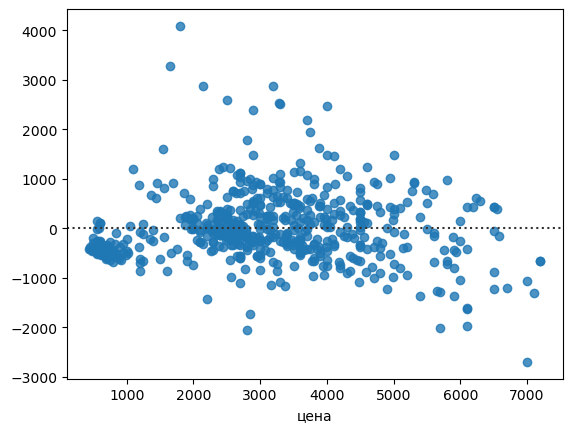

In [38]:
graph = sns.residplot(x=Y, y=preds)

Text(0.5, 9.444444444444438, 'residuals')

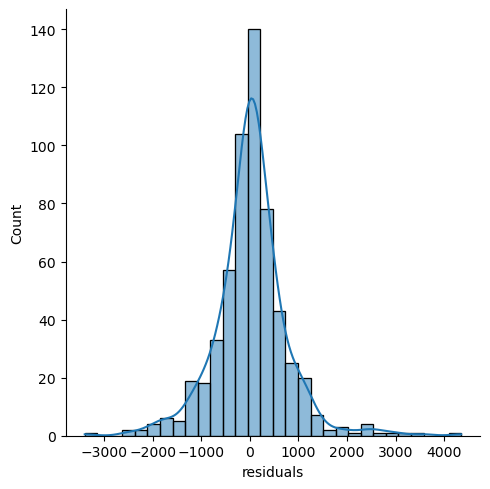

In [39]:
sns.displot(residuals, bins=30, kde=True)
plt.xlabel('residuals')

In [40]:
Y.iloc[:25]

Код объекта
5757236    2390.0
5535905     920.0
4644398    3250.0
5667276    3590.0
4644417    4500.0
3854655    2550.0
5757173    3000.0
5103276     800.0
5758058    4700.0
4525390    2970.0
4469870    4000.0
5760725    2450.0
5553000     570.0
4265258    4200.0
2987059    1190.0
5759101    2700.0
3598170    1999.0
5109065    3200.0
5758617    5500.0
5593171     649.0
5751111    4000.0
5760211    2350.0
3602019     590.0
4522037     700.0
3684339     990.0
Name: цена, dtype: float64

In [41]:
preds[:25]

array([3740.44444444,  707.125     , 3886.58333333, 3017.63636364,
       5072.25      , 3886.58333333, 3509.        ,  707.125     ,
       5365.        , 3108.90909091, 3886.58333333, 2528.57894737,
        707.125     , 4364.14285714, 2442.57142857, 2227.14285714,
       1490.        , 3982.5       , 5072.25      ,  581.        ,
       3400.55555556, 2819.28571429,  707.125     ,  828.42857143,
        865.71428571])

## Checking dummmy predictions
predict price based on flat_type

In [42]:
raise notImplementedErro()

NameError: name 'notImplementedErro' is not defined

In [ ]:
means = X.join(Y).groupby('Серия')['цена'].mean()
means

In [ ]:
dummy_preds = X['Серия'].transform(lambda x: means[x]).values

In [ ]:
mean_squared_error(dummy_preds,Y)

In [ ]:
mean_absolute_error(dummy_preds,Y)

In [ ]:
graph = sns.residplot(x=dummy_preds, y=Y)


In [ ]:
residuals_dummy = dummy_preds - Y

In [ ]:
sns.displot(residuals_dummy, bins=30, kde=True)
plt.xlabel('residuals')

### models performs better then dummy regressor
I conclude that model works

In [ ]:
model.get_params()

In [ ]:
import pickle

In [ ]:
model.fit(X, Y)

In [ ]:
#with open("model.pkl", "wb") as f:
#    pickle.dump(model, f)

In [ ]:
#with open("model.pkl", "rb") as f:
#    derevo = pickle.load(f)